In [81]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw1.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science
## Homework 1: Webscraping, Pandas, and EDA

**Harvard University**<br/>
**Fall 2025**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Gumb

<hr style="height:2.4pt">

In [82]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import pyarrow as pa # optional
import seaborn as sns
import matplotlib.pyplot as plt
import re
import io
import os.path
import json
import time
import glob
# import asyncio # optional
import aiohttp # optional
from IPython.core.display import HTML
from IPython import display

import wikipedia
from wikipedia.exceptions import DisambiguationError, PageError

import pandas as pd
from concurrent.futures import ThreadPoolExecutor
# import asyncio
from collections import defaultdict

from threading import Lock

In [83]:
# For calculating total notebook runtime
notebook_start = time.time()

In [84]:
style = '''<style>
h3, h4 {
    background-color: #7efcf5;
    border-left: 5px solid #7ec4fc;
    border-right: 5px solid #7ec4fc;
    padding: 0em;
}
h3 {
    background-color: #7efcf5;
    border-top: 5px solid #7ec4fc;
    border-left: 5px solid #7ec4fc;
    border-right: 5px solid #7ec4fc;
    padding: 0.5em;
}
p {
    padding: 0.5em;
    max-width: 34em;
    font-weight:400;
}
.md {
    max-width: 80ch;

}
.prompt {    
    background-color: lightgreen;
    border-color: #dFb5b4;
    border-left: 5px solid #f57efc;
    padding: 0.5em;
    font-weight:500;
    }
 </style>'''
HTML(style)

## Assignment Overview

You'll be working with data from screenboston.com, a website that aggregates movie screenings from various theaters in the Boston area. Your task is to collect this data, enrich it with information from Wikipedia, and then analyze and visualize the results.

## Assignment Structure

The assignment is divided into 8 main questions, each building upon the previous ones, followed by a wrap-up:

1. Fetching HTML from screenboston.com (10 pts)
2. Parsing HTML into structured data (15 pts)
3. Augmenting data with historical snapshots (15 pts)
4. Creating and manipulating a Pandas DataFrame (15 pts)
5. Initial exploratory data analysis and visualization (15 pts)
6. Finding Wikipedia pages for each screened film (7 pts)
7. Storing Wikipedia HTML in the DataFrame (3 pts)
8. Extracting and analyzing data from Wikipedia pages (15 pts)
9. Wrap-up (5 pts)

As you progress through these steps, you'll be transforming raw web data into a rich dataset ready for analysis. By the end, you'll have created a comprehensive overview of Boston's movie screening landscape, potentially uncovering interesting trends and patterns in the process. 

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with very long output. Or better yet, avoid overly long output altogether.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>


<div class=md>
<h3>1. Getting HTML from screenboston.com</h3>

<p>Our first step is to get the HTML content from the page at screenboston.com for analysis. To avoid having to make unnecessary future requests, you should write the content to disk.</p>



<div class=prompt>
    
1. Use the `requests` library to get the html located at screenboston.com.
1. Save it in the file `data/html/screenboston.html`.

**Your code should only make an HTTP request if the file does not already exist.** 

**Hint:** the `os.path.isfile()` function can be used check if a file exists.
</div>
</div>


In [85]:
def read_file(filename: str):
    if not os.path.isfile(filename):
        return ""
        
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()
    
def write_file(filename: str, content: str):
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(content)
        
def fetch_html_data(url: str, filename: str):
    response = requests.get(url)
    response.raise_for_status()
    
    html_content = response.text
    write_file(filename, html_content)
    
    return html_content

def load_movie_info():
    filename = 'data/html/screenboston.html'
    content = read_file(filename)
    
    if content:
        return content
    
    url = 'https://screenboston.com/'
    try:
        content = fetch_html_data(url, filename)
    except Exception as e:
        print(f"[Error] Failed to fetch data from {url}: {e}")
    
    return content
            
html_content = load_movie_info()

In [86]:
grader.check("q1")

q1 results: All test cases passed!

<div class=md>
<h3>2. Parsing HTML into an Efficient Data Structure</h3>

<p>Were you to open this HTML file in an editor, you'd find it wouldn't make for light reading.
There's a lot of text in there, but we're currently only interested in a small portion of it. Thankfully, this small portion's constituant occurances appear in a mostly predictable way.
</p>

<div class='prompt'>
1. Parse the HTML page to produce an iterable of dictionaries called <code>movies</code>. Here is one possible example:
<div style="max-width:30em;padding:1em">
    
```python
{'title': 'Monty Python and the Holy Grail',
 'directors': 'Terry Jones, Terry Gilliam',
 'year': 1975,
 'genre': 'Adventure',
 'runtime': '1h 31m',
 'theater': 'Coolidge Corner Theater',
 'screen_date': '2024-08-17'
 'screen_times': '11:59 PM'}
```
</div>

2. Report the number of dictionaries in your iterable.
3. Display an example dictionary.
</div>

<p>
<b>One possible approach:</b> leveraging the structure of the page, use BeautifulSoup to divide it into disjoint peices of the HTML tree, each containing the set of information outlined above for each title's screening date at a given theater. Each peice is processed by a helper function(s) which extracts the desired fields and assemples them into a dictionary. These dictionaries are then accumulated in some iterable such as a list.
</p>

**Hints:**
- Your browser's 'inspect' tool is very useful for exploring a page's structure.
- To maintain a uniform set of keys across all movie dictionaries, use the plural 'directors' even for movies which attribute only a single director. 
</div>
</div>

In [87]:
def extract_movies(content: str):
    soup = BeautifulSoup(content)
    
    # Find all movies by their screen dates
    all_movies = soup.find_all(
        "div",
        class_="max-w-screen",
        id=re.compile(r"\d{4}-\d{2}-\d{2}")
    )
    
    # print(len(all_movies))

    movie_selector = 'div.md\\:col-span-3.min-w-0.justify-between.gap-4.md\\:gap-1.flex.flex-col.w-full.sm\\:h-full'
    title_selector = 'p.big.whitespace-normal.w-full.min-w-0.overflow-hidden'

    movies = []
    
    # Process each showing group
    for grp in all_movies:
        screen_date = grp.get('id')
        
        # Split each showing group into individual movies
        grp_movies = grp.select(movie_selector)
        for movie_item in grp_movies:
            # Extract all properties of a movie except for title
            details = movie_item.find_all("p", class_=lambda c: c in (None, ""))
            
            # Split line for year, genre and runtime
            movie_props = details[1].text.split(',')
            
            # Some movies have year and runtime, others have year, genre and runtime
            genre = movie_props[1].strip() if len(movie_props) > 2 else ""
            runtime = movie_props[2].strip() if len(movie_props) > 2 else movie_props[1].strip()
            
            # Create and append movie
            movies.append({
                'title': movie_item.select_one(title_selector).text.strip(),
                'directors': details[0].text.strip(),
                
                'year': int(movie_props[0].strip()),
                'genre': genre,
                'runtime': runtime,
                
                'theater': details[2].text.strip(),
                'screen_date': screen_date,
                'screen_times': details[3].text.strip(),
            })
    return movies

In [88]:
movies = extract_movies(html_content)

In [89]:
grader.check("q2")

q2 results: All test cases passed!

<div class=md>
    <h3>3. Adding Historical Data: Snapshots from the Internet Archive's Wayback Machine</h3>
<p>
The screenboston.com page only shows screenings scheduled from the current day until about 2-4 weeks into the future.
Using the <a href="http://web.archive.org/">Wayback Machine</a>, we can augment our dataset with past snapshots of the page  
</p>

<p>
Rather than clicking around to download each snapshot manually, we should again acquire our pages programmatically using <code>requests</code>. The Internet Archive offers an <a href='https://archive.org/help/wayback_api.php'>API</a> where you can specify a URL and timestamp and receive a JSON object which contains a new URL to a snapshot of the desired page nearest to the provided timestamp. You can then use <code>requests</code> again to acquire the HTML of this snapshot.
</p>
    
<div class=prompt>

1. Acquire enough snapshots to cover all days from Jan through September 2024 for which there exists data. 
For simplicity we'll assume that any well-formed screenboston.com page will cover at least through the end of that month and that a day's schedule won't change once displayed.
2. Write each snapshot's HTML content to disk in the `/data/html` directory using filenames of the form `'snapshot_YYYYMMDD.html'`. Your code should only make requests if no local snapshot files already exist.
3. Using your parsing function from the previous section, add movie dictionaries extracted from all the snapshots to your list, `movies`. Save this list of dictionaries as 'data/movies.json'. You should only perform the parsing if the JSON file does not already exist. Don't worry about any duplicate movie screenings in your list at this point.

</div>

**Hints:**
- When retrieving JSON content with <code>requests</code>, us the `json()` method rather than the `text` attribute to extract the content from the returned request object into a nested dictionary rather than a string.
- APIs often take parameters as key-value pairs occuring after a '?' character in the URL. For example 'http://archive.org/wayback/available?url=example.com&timestamp=20060101' includes a 'url' and a 'timestamp' parameter. When using <code>requests.get()</code> you can exclude these parameters from the URL itself and instead pass them as a dictionary to an argument called 'params'.
- Use <code>json.dump()</code> and <code>json.load()</code> from the imported <code>json</code> module for writing and reading JSON content.

In [90]:
MAX_RETRIES = 5
SLEEP_SECONDS = 2
WAYBACK_API = 'http://archive.org/wayback/available/'

def get_snapshot_url(date_str: str):
    """
    Checks the availability of a snapshot on a Wayback Machine and returns the url
    to the archive if found.
    
    - If snapshot is not available, the check is retried due to quirks in the api response.
    - Returns the archive url if found.
    """
    for _ in range(MAX_RETRIES):
        params = {
            'url': 'screenboston.com',
            'timestamp': date_str,
        }
        response = requests.get(WAYBACK_API, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Check snapshot availability
        snapshot = data.get('archived_snapshots', {}).get('closest', None)
        if snapshot and snapshot.get('available', False):
            return snapshot['url']
        
        time.sleep(SLEEP_SECONDS)
        
    # Snapshot not found
    return ""

def load_archived_data(date_str: str):
    """
    Loads archived movie data for the given timestamp.
    
    - Uses local snapshots if available.
    - Otherwise the snapshot is fetched from Wayback Machine if available.
    """
    # Try read file from disk
    filename = f'data/html/snapshot_{date_str}.html'
    content = read_file(filename)
    
    if content:
        return content
    
    # Check if archive is available and fetch it
    url = get_snapshot_url(date_str)
    if url:
        return fetch_html_data(url, filename)
    
    return ""

def save_movies():
    filename = 'data/movies.json'
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(movies, f, indent=2, ensure_ascii=False)

In [91]:
# We use the first day of each month to fetch the snapshot.
# This is on the assumption that the page fetched will cover the month.
# Also, the availability check will return the closest available timestamp.
date_strs = [
    '20240101', 
    '20240201', 
    '20240301', 
    '20240401',
    '20240501', 
    '20240601', 
    '20240701', 
    '20240801', 
    '20240901'
]
for date_str in date_strs:
    data = load_archived_data(date_str)
    extracted_movies = extract_movies(data)
    movies.extend(extracted_movies)
    
save_movies()

In [92]:
# Display info about snapshots and results of parsing
print(f"Snapshots:")
print([f.split('/')[-1] for f in glob.glob('data/html/snapshot_*')])
print(f"Found {len(movies)} movie entries across all HTML files.")

Snapshots:
['snapshot_20240601.html', 'snapshot_20240401.html', 'snapshot_20240801.html', 'snapshot_20240201.html', 'snapshot_20240701.html', 'snapshot_20240501.html', 'snapshot_20240901.html', 'snapshot_20240101.html', 'snapshot_20240301.html']
Found 625 movie entries across all HTML files.


In [93]:
grader.check("q3")

q3 results: All test cases passed!

<div class=md>
    
<h3>4. DataFrame Creation & Manipulation</h3>

Your variable `movies` is a list of dictionaries which you can use to create a Pandas DataFrame. Have our data in a DataFrame will make it much easier to analyze and manipulate.

<div class=prompt>
    
1. Use `movies` to create a DataFrame and call it `df`
2. Drop any **duplicate rows** and report the number of remaining rows. Here we consider duplicates to be rows in which *all* values match. The same movie screening on different days, even at the same theater, will not be considered a duplicate.
3. Check for **nans**. If you find any nans you should report the number of nans in each column and display the rows that contain at least one nan. If there are no nans then you should display output to confirm this fact.
4. Convert the **'screen_date'** to a Pandas `datetime` dtype and **'runtime'** to a Pandas `timedelta` dtype.
5. Sort your `df` by ascending 'screen_date'
</div>

Your result should look something like:

| title                            | directors       | year | genre  | runtime         | theater                   | screen_date | screen_times         |
|-----------------------------------|-----------------|------|--------|-----------------|---------------------------|-------------|----------------------|
| Ghost Dog: The Way of the Samurai | Jim Jarmusch    | 1999 | Crime  | 0 days 01:56:00 | The Brattle               | 2024-05-24  | 4:00 PM, 9:00 PM     |
| Stray Dog                        | Akira Kurosawa  | 1949 | Crime  | 0 days 02:02:00 | The Brattle               | 2024-05-24  | 6:30 PM              |
| Big Trouble in Little China       | John Carpenter  | 1986 | Comedy | 0 days 01:40:00 | Coolidge Corner Theatre    | 2024-05-24  | 11:59 PM             |
| Young Frankenstein               | Mel Brooks      | 1974 | Comedy | 0 days 01:46:00 | The Brattle               | 2024-05-25  | 12:00 PM             |
| Poetry                           | Lee Chang-dong  | 2010 | Drama  | 0 days 02:19:00 | Museum of Fine Arts        | 2024-05-25  | 2:30 PM              |

**Hints:**
- You can use the `dt.date` attribute on a datetime column to extract just the day (and ignore the time)
- You may need to to do some string parsing on 'runtime' before coverting it to a `timedelta`
- Pandas now supports [PyArrow](https://arrow.apache.org/docs/python/index.html) as a backend alternative to Numpy. This gives access to new datatypes including native strings (as opposed to the catch-all 'object'), ints that support NaN values, and others. Using these datatypes can often speed up computations so you may choose to experiment with converting some or all of your columns to these new datatypes. You can read more [here](https://pandas.pydata.org/docs/user_guide/pyarrow.html).
</div>

In [94]:
# Create movies dataframe
df = pd.DataFrame(movies)

# Drop duplicate movie screening
df = df.drop_duplicates()

# Aggregate NaN's per column
nan_count = df.isna().sum()
print("Number of NaNs per Column:")
nan_count

Number of NaNs per Column:


title           0
directors       0
year            0
genre           0
runtime         0
theater         0
screen_date     0
screen_times    0
dtype: int64

In [95]:
# Find all rows that have NaN in any column
nan_df = df[df.isna().any(axis=1)]
print(f"\nRows with NaNs: {len(nan_df)}")
nan_df


Rows with NaNs: 0


,title,directors,year,genre,runtime,theater,screen_date,screen_times


In [96]:
# Drop rows with NaN
df = df.dropna()

# Convert screen_date and runtime columns to dtype datetime and timedelta
df["screen_date"] = pd.to_datetime(df["screen_date"], errors="coerce")
df["runtime"] = pd.to_timedelta(df["runtime"])

# Sort dataframe by ascending screen_date
df = df.sort_values(by="screen_date", ascending=True)

# Display the dataframe's head
# Hide index, format screen_date, align texts to the left and add borders
df.head().style.hide(axis="index")\
    .format({'screen_date': lambda t: t.strftime("%Y-%m-%d")})\
    .set_table_styles([
        {
            'selector': 'td, th', 
            'props': [
                ('text-align', 'left'), 
                ('border', '1px solid white')
            ]
        }
    ])

title,directors,year,genre,runtime,theater,screen_date,screen_times
Ghost Dog: The Way of the Samurai,Jim Jarmusch,1999,Crime,0 days 01:56:00,The Brattle,2024-05-24,4:00 PM
Big Trouble in Little China,John Carpenter,1986,Comedy,0 days 01:40:00,Coolidge Corner Theatre,2024-05-24,11:59 PM
Stray Dog,Akira Kurosawa,1949,Crime,0 days 02:02:00,The Brattle,2024-05-24,6:30 PM
Young Frankenstein,Mel Brooks,1974,Comedy,0 days 01:46:00,The Brattle,2024-05-25,12:00 PM
Poetry,Lee Chang-dong,2010,Drama,0 days 02:19:00,Museum of Fine Arts,2024-05-25,2:30 PM


In [97]:
grader.check("q4")

q4 results: All test cases passed!

<div class=md>
    
<h3>5. Initial Exploratory Data Analysis (EDA)</h3>

Using your DataFrame, perform the following exploratory data analysis tasks. Note that we'll use the term "screening" to refer to rows in the DataFrame example provided above. For each visualization component of this question you should interpret the results and draw conclusions.

<div class=prompt>

1. **Longest Films**:
   Display the rows corresponding to the top 5 longest reported runtimes in descending order.

2. **Screening Counts**:
   Create two plots as side-by-side subplots with a shared y-axis range:\
   a. Number of screenings by theater\
   b. Number of screenings by genre

3. **Movie Year Analysis**:
   Create two separate plots:\
   a. Distribution of 'year' for all movies\
   b. Distribution of 'year' grouped by theater

4. **Custom Analysis**:
   Ask two questions of your choice regarding the screening data and use plots to attempt to find some answers. For each question:\
   a. Clearly state your question\
   b. Explain your approach to answering the question\
   c. Create an appropriate visualization
   
   At least one of these new plots must be a different type from those used in parts 2 and 3.

Example questions you might consider:
- Is there a relationship between a movie's age (current year - release year) and the number of screenings it receives?
- Do certain genres tend to have longer runtimes?
- Are there patterns in screening times for different theaters or genres?
- How does the distribution of genres vary across different theaters?


</div>
</div>

In [98]:
# 1. Longest films
# Top 5 movies with longest runtime
top_five_runtimes = df.sort_values(by="runtime", ascending=False).iloc[0:5]

# Display dataframe
# Hide index, format screen_date, align texts to the left and add borders
top_five_runtimes.style.hide(axis="index")\
    .format({'screen_date': lambda t: t.strftime("%Y-%m-%d")})\
    .set_table_styles([
        {
            'selector': 'td, th',
            'props': [
                ('text-align', 'left'), 
                ('border', '1px solid white')
            ]
        }
    ])

title,directors,year,genre,runtime,theater,screen_date,screen_times
Menus-Plaisirs - Les Troisgros,Frederick Wiseman,2023,Documentary,0 days 04:00:00,Museum of Fine Arts,2024-08-03,12:30 PM
Lawrence of Arabia,David Lean,1962,Adventure,0 days 03:48:00,Coolidge Corner Theatre,2024-09-15,2:00 PM
Ben-Hur,William Wyler,1959,History,0 days 03:42:00,Somerville Theatre,2024-06-22,2:00 PM
"Jeanne Dielman, 23, quai du Commerce, 1080 Bruxelles",Chantal Akerman,1976,Drama,0 days 03:22:00,The Brattle,2024-08-04,6:30 PM
Spartacus,Stanley Kubrick,1960,History,0 days 03:17:00,Coolidge Corner Theatre,2024-09-23,7:30 PM


### Observations
1. The longest films all have very long runtimes, each well over 3 hours with the longest at 4 hours.
2. Screening time for the longest films are mostly in the afternoon. 4 out of the 5 starts between 12:30 PM and 2:00PM with one showing at 3:30 PM

### Conclusions
Very long movies are usually screened in the afternoon or early evening.

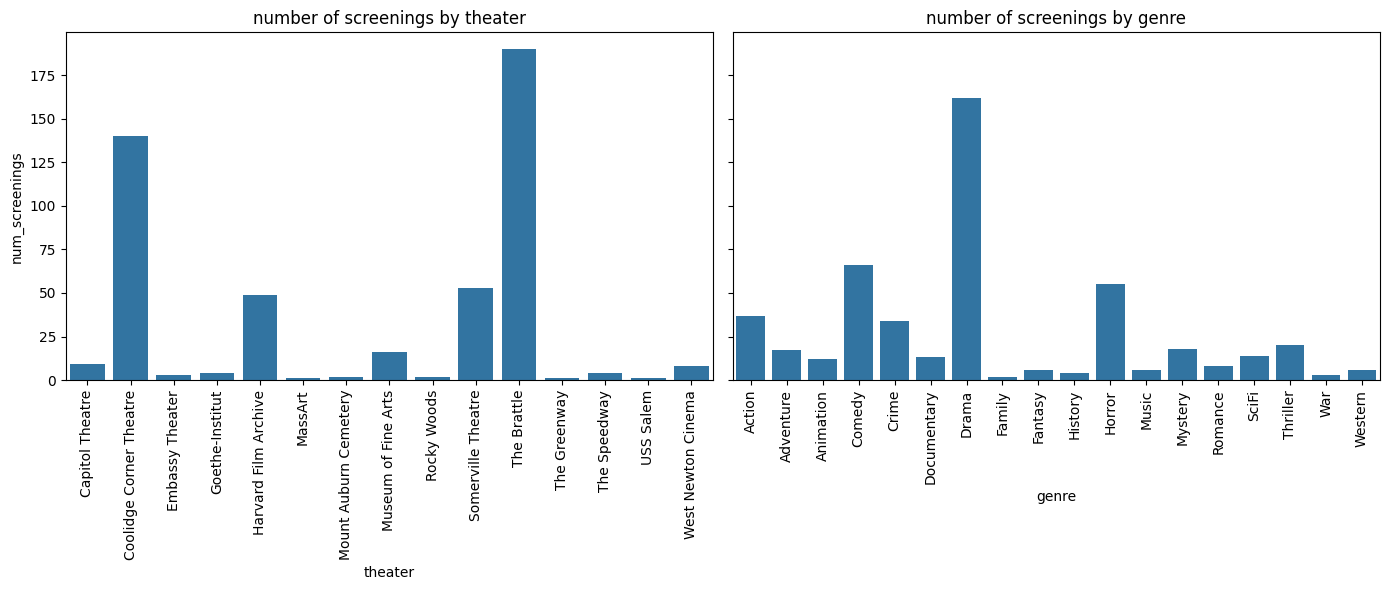

In [99]:
# 2. Screenings by theater & screenings by genre
screenings_by_theater = df.groupby('theater').size().reset_index(name='num_screenings')

screenings_by_genre = df.groupby('genre').size().reset_index(name='num_screenings')
# Remove empty genres
screenings_by_genre = screenings_by_genre[screenings_by_genre['genre'].str.strip() != '']

plot_data = [(screenings_by_theater, 'theater'), (screenings_by_genre, 'genre')]
fig, axs = plt.subplots(1, 2, figsize=(14,6), sharey=True)
for i, (data, movie_title) in enumerate(plot_data):
    sns.barplot(
        data=data, x=movie_title, y='num_screenings', ax=axs[i]
    ).set_title('number of screenings by ' + movie_title)
    axs[i].tick_params(axis='x', rotation=90)
plt.tight_layout()

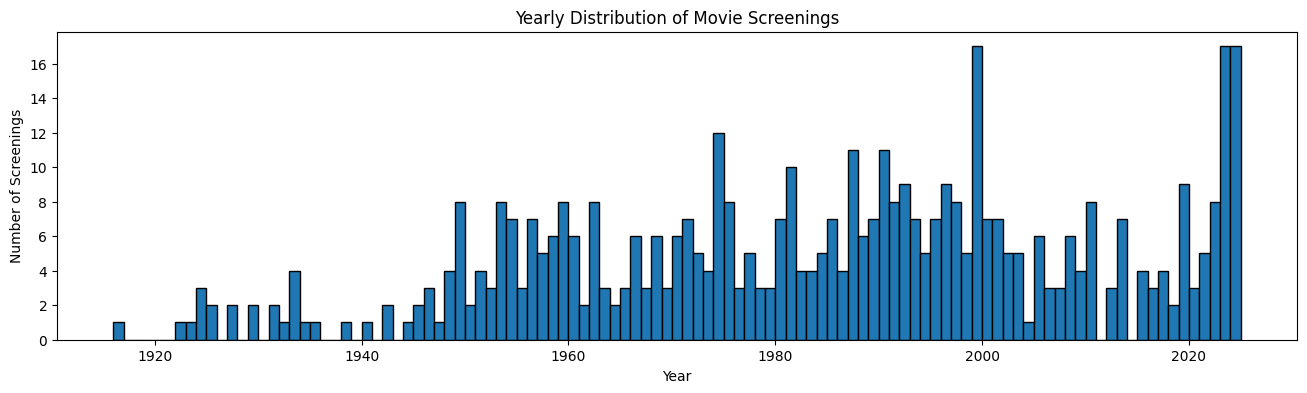

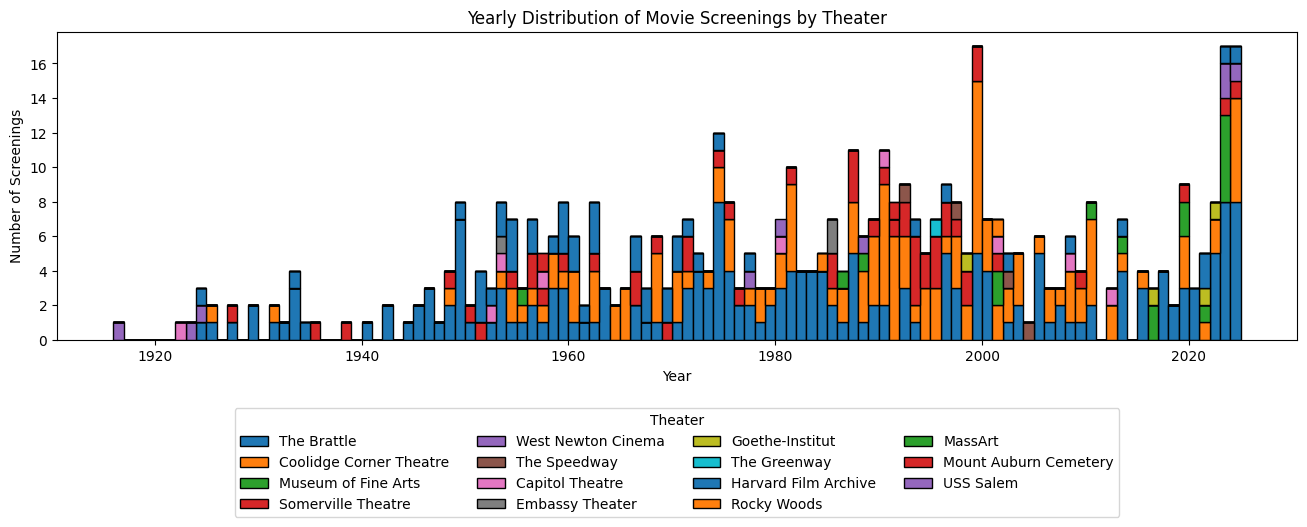

In [100]:
plt.figure(figsize=(16,4))
plt.hist(df['year'], bins=range(df['year'].min(), df['year'].max()+1, 1), edgecolor='black')
plt.xlabel("Year")
plt.ylabel("Number of Screenings")
plt.title("Yearly Distribution of Movie Screenings")
plt.show()

theaters = df['theater'].unique()
plt.figure(figsize=(16,4))
plt.hist(
    [df[df['theater'] == t]['year'] for t in theaters], 
    bins=range(df['year'].min(), df['year'].max()+1), 
    stacked=True, 
    label=theaters,
    edgecolor='black'
)

plt.xlabel("Year")
plt.ylabel("Number of Screenings")
plt.title("Yearly Distribution of Movie Screenings by Theater")
plt.legend(title="Theater", ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.2))
plt.show()


Observations:
1. This an upward trend in the number of film screenings over time.
2. Movie screenings were sparse before the 1945s and concentrated in very few theaters.
3. There are fluctuations in the number of screenings between 1945 and 2025.
4. The largest number of screenings occurred in 2000, 2018 and 2024 and 2025, with peaks in 2018 and 2025.
5. Brattle and Rocky Woods are the dominant theaters.
6. Embassy Theater, Harvard Film Archive and The Speadway theaters, contributed the least number of screenings.

Conclusions
1. Cinema activities experienced growth over time with a few dominant theaters consistently accounting for a large portion of screenings.
2. There are more theaters screening movies in recent years than in the early years.
3. Further studies could be conducted to understand the cause of the spikes seen in some years.

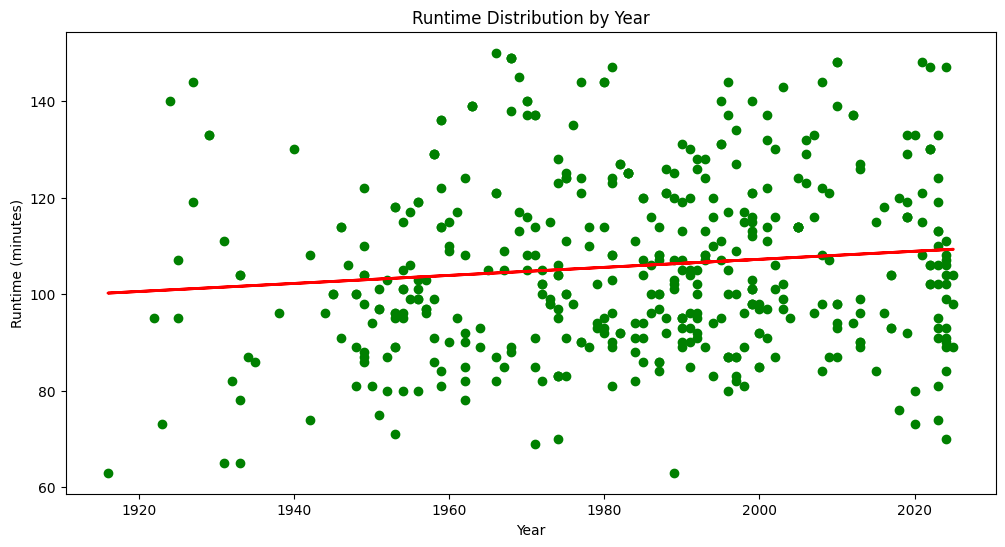

In [101]:
# 4.1 Custom question 1 - Runtime Distributions by Year (Scatter with Trend Line, Outliers Removed but Included in Regression)

# Convert runtime to minutes first
df['runtime_minutes'] = df['runtime'].dt.total_seconds() / 60

# Remove outliers
filtered_df = df[(df['runtime_minutes'] >= 50) & (df['runtime_minutes'] <= 150)]

plt.figure(figsize=(12, 6))
plt.scatter(data=filtered_df, x='year', y='runtime_minutes', color='green')

# Fit linear regression line
x = filtered_df['year'].values 
y = filtered_df['runtime_minutes'].values
m, b = np.polyfit(x, y, 1)  # slope, intercept

# Add line to plot
plt.plot(x, m*x + b, color='red', linewidth=2, label="Trend line")

plt.title("Runtime Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Runtime (minutes)")
plt.show()

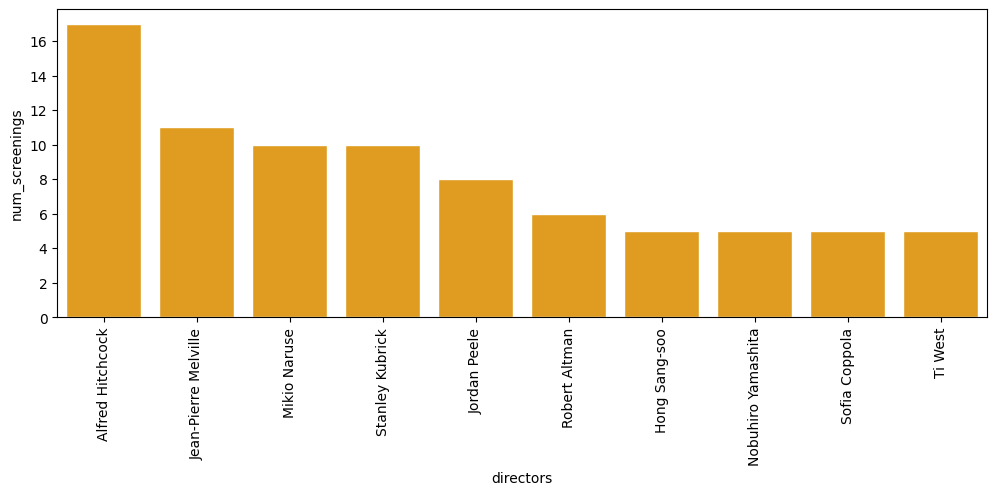

In [102]:
# 4.2 Custom question 2 - Top 10 Directors by Number of Screenings (Aesthetic Improvements)
# your code here
top_10_dirs = df.groupby('directors').size().reset_index(name='num_screenings')
top_10_dirs = top_10_dirs.nlargest(10, 'num_screenings')
# top_10_dirs

plt.figure(figsize=(12,4))
plt.xticks(rotation=90)
with sns.axes_style('whitegrid'):
    sns.barplot(data=top_10_dirs, x='directors', y='num_screenings', color='orange')


<div class=md>
<h3>6. Get each film’s Wikipedia page identifier</h3>

Use the Wikipedia Python library to find a stable identifier for each film’s Wikipedia page and store it in a new `wiki_id` column. Prefer the numeric page ID (`page.pageid`); a canonical article URL is acceptable. Display the head of your updated DataFrame and briefly describe your approach. Aim for at least 50% coverage.

<strong>Hints:</strong>
- Set up the library: `wikipedia.set_lang("en")` and `wikipedia.set_rate_limiting(True)`.
- Build your search query from known fields (e.g., title + year + "film" [+ director if helpful]).
- Use `wikipedia.search(...)`, then fetch a page with `wikipedia.page(..., auto_suggest=True)`.
- Extract a stable ID: `page.pageid` (preferred) or `page.url`.
- Handle `DisambiguationError` and `PageError`; return `None` when you’re not confident.
- Cache results (e.g., write `wiki_id` to a CSV and only query rows where it’s missing).
- Optional: use a small thread pool for speed, but keep concurrency low to be polite to Wikipedia.


<strong>Optional performance hints (polite concurrency):</strong>
- The <code>wikipedia</code> calls are blocking I/O. If you want to speed things up, use a small <code>ThreadPoolExecutor</code> (threads are appropriate for I/O). Keep <code>max_workers</code> low (2–4; at most ~8) and enable <code>wikipedia.set_rate_limiting(True)</code>.
- Simple threaded map (no asyncio):
  
  ```python
  from concurrent.futures import ThreadPoolExecutor

  wikipedia.set_rate_limiting(True)

  def get_wiki_id_for_movie(row):
      # your blocking lookup; return pageid or None
      ...

  rows = df.to_dict("records")
  with ThreadPoolExecutor(max_workers=3) as ex:
      wiki_ids = list(ex.map(get_wiki_id_for_movie, rows))
  df["wiki_id"] = wiki_ids
  ```
- If you prefer <code>asyncio</code>, you can run the blocking function in a thread pool and gather results:
  
  ```python
  import asyncio
  from concurrent.futures import ThreadPoolExecutor

  async def get_wiki_ids_async(rows, max_workers=3):
      loop = asyncio.get_running_loop()
      with ThreadPoolExecutor(max_workers=max_workers) as ex:
          tasks = [loop.run_in_executor(ex, get_wiki_id_for_movie, r) for r in rows]
          return await asyncio.gather(*tasks)

  wiki_ids = await get_wiki_ids_async(df.to_dict("records"), max_workers=3)
  df["wiki_id"] = wiki_ids
  ```
- Cache results to disk so you don’t repeat requests. Handle <code>DisambiguationError</code>/<code>PageError</code> and return <code>None</code> gracefully.


<strong>Ensure that :</strong>
- `df` has a `wiki_id` column.
- ≥50% of `wiki_id` are non-null.
- You show the head of the updated DataFrame and briefly describe your approach.

</div>

In [111]:
def read_wiki_ids(path: str):
    """Read wiki page IDs from disk and cache in a dictionary using pandas"""
    if not os.path.isfile(path):
        return dict()
    
    df_cache = pd.read_csv(path)
    
    # Expecting columns: query, wiki_ids
    return dict(zip(df_cache["query"], df_cache["wiki_id"]))

In [112]:
# Custom question 2 - Retrieving Wikipedia page IDs for movies
wikipedia.set_lang('en')
wikipedia.set_rate_limiting(True)

# We will cache previously fetched wiki_ids in a dictionary for the threads
# to share. To avoid race conditions, we will need a lock
wiki_ids_dict_lock = Lock()
wiki_ids_dict = read_wiki_ids("data/wiki_ids.csv")

In [113]:
def write_wiki_ids(path: str):
    """Write cached wiki IDs dictionary back to CSV using pandas."""
    df_cache = pd.DataFrame([
        {"query": query, "wiki_id": wiki_id}
        for query, wiki_id in wiki_ids_dict.items()
    ])
    df_cache.to_csv(path, index=False)

In [105]:
def build_film_query(title: str, year=None, director=None):
    parts = [title]
    if year:
        parts.append(str(year))
        
    parts.append("film")
    
    if director:
        parts.append(director)
        
    return " ".join(parts)

def directors_match(expected, actual):
    """
    Checks if all expected directors are in the actual directors text
    Both inputs can contain multiple names separated by commas
    """
    norm_expected = set(item.strip().lower() for item in re.split(r",|and", expected))
    norm_actual = set(item.strip().lower() for item in re.split(r",|and", actual))
    return norm_expected.issubset(norm_actual)

In [114]:
def match_movie_info(page, movie_title: str, yr: None, directors=None):
    # Must match film title or return 
    if not movie_title.lower() in page.title.lower():
        return 0
    
    # Process page
    total_matches = 0
        
    # Check for film in title
    if "film" in page.title.lower():
        total_matches += 1
    
    soup = BeautifulSoup(page.html())
        
    infobox = soup.find("table", class_="infobox vevent")
    if infobox is None:
        return total_matches
    
    info_rows = infobox.find_all("tr")
    for data_row in info_rows:
        th = data_row.find("th")
        if th is None:
            continue
        
        th_text = th.get_text(" ", strip=True).lower()
        td = data_row.find("td")
        td_text = td.get_text(" ", strip=True).lower() if td else ""
        
        # Match directors
        if "directed by" in th_text:
            if directors_match(directors, td_text):
                total_matches += 1
                
        # Match year
        elif yr and "release date" in th_text:
            if str(yr) in td_text:
                total_matches += 1
    
    return total_matches

In [115]:
def get_wiki_id_for_movie(movie_info: dict):
    """Fetch Wikipedia page ID for a given movie"""
    movie_title = movie_info.get('title', '')
    yr = movie_info.get('year', None)
    directors = movie_info.get('directors', '')
    
    # Build search query with title, year and directors' names
    search_query = build_film_query(movie_title, yr, directors)
    
    # If the id exists in the catch, we return it
    # Lock before reading, to avoid race conditions
    with wiki_ids_dict_lock:
        if page_id := wiki_ids_dict.get(search_query, None):
            return page_id
        
    try:
        # Search wikipedia for movie
        search_result = wikipedia.search(search_query)
        
        # No matching result
        if not search_result:
            return None
        
        # Process search results for a match
        # Check at most first 5 pages in the search result for a match
        max_search = min(5, len(search_result))
        for i in range(max_search):
            try:
                page = wikipedia.page(search_result[i], auto_suggest=True)
                if match_movie_info(page, movie_title, yr, directors) < 2:
                    continue
                
                # If matched the title and any two of directors, year and film,
                # cache the pageid and return it
                # Lock cache before writing to it
                with wiki_ids_dict_lock:
                    wiki_ids_dict[search_query] = page.pageid
                    
                return page.pageid
            except (DisambiguationError, PageError):
                continue 
            
        # No match found
        return None
    except Exception as e:
        print(f"Unexpected error for {search_query}: {e}")
        return None

In [ ]:
# def fetch_movies_wiki_pages():
#     # # Update wiki_ids cache from disk
#     # wiki_ids_dict = read_wiki_ids("data/wiki_ids.csv")
    
#     # Fetch page ID for each movie and update movies data frame
#     rows = df.to_dict(orient="records")
#     with ThreadPoolExecutor(max_workers=2) as ex:
#         wiki_ids = ex.map(get_wiki_id_for_movie, rows)
#     df['wiki_id'] = list(wiki_ids)
    
#     # Save cached wiki page IDs
#     write_wiki_ids("data/wiki_ids.csv")

In [ ]:
# fetch_movies_wiki_pages()
batch_wiki_ids = []
rows = df.to_dict(orient="records")
batch_size = 50
for i in range(0, len(rows), batch_size):
    with ThreadPoolExecutor(max_workers=3) as ex:
        wiki_ids = ex.map(get_wiki_id_for_movie, rows[i:i+batch_size])
    batch_wiki_ids.extend(list(wiki_ids))
    
    # Sleep for 1 second
    print(f"saving wiki ids")
    time.sleep(1)

df['wiki_id'] = batch_wiki_ids

print("saving wiki ids")

# Save cached wiki ids to disk for reuse
write_wiki_ids("data/wiki_ids.csv")

# display head of the updated dataframe
df.head()

/Users/alfred.okoronkwo/Projects/hues_programs/cscie_1090a/cs1090a_hw1/.venv/lib/python3.13/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/alfred.okoronkwo/Projects/hues_programs/cscie_1090a/cs1090a_hw1/.venv/lib/python3.13/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


saving wiki ids
saving wiki ids
saving wiki ids
saving wiki ids


In [ ]:
# Display results of updated df
missing_rows = df[df.wiki_id.isna()]
num_wiki_id_na = missing_rows.shape[0]
print("Number of screenings missing a wiki ID:", num_wiki_id_na)
if num_wiki_id_na > 0:
    print("Example rows with missing wiki ID")
    display.display(missing_rows)

#### My Approach
My approach is to create a search query with movie title, film, release year and directors. This query is used to search Wikipedia for matching pages. The topmost five pages from the search result are parse to check whether any contains the attributes in the query. A page is considered a match if it includes the movie title and at least two of the following: release year, directors, or the word film. Although this method is somewhat aggressive, it increases the likelihood that any matched page is the correct Wikipedia entry for the movie.

First, previously discovered page ids are read from disk and cached in a dictionary, allowing for faster lookups when a pageid already exist for a query. To speed up searches, a ThreadPoolExecutor with two worker threads is used to parallelize requests to Wikipedia. Before a new search is performed, the cache is checked for an existing page ID. A Wikipedia search is only executed if no cached ID is found.

Parsing search results involves checking whether the movie title is present in the page title, extracting the infobox table, and verifying the presence of the release date and directors. The page title is also checked for the word film. If a page satisfies the condition of containing the movie title and any two of release year, director, or film, it is considered a match, and its page ID is returned. To minimize processing overhead, only the top five search results are examined, as these are the most likely to correspond to the movie. All comparisons are case-insensitive.

The text below is left as is from the downloaded notebook.

With these missed pages the above approach is still suboptimal.
The code makes aysnyc wikipedia searches of the form '\<title> \<director> film'. It then goes through the search result pages until it finds one in which half of its 'categories' (listed at the bottom of a Wikipedia page) are contain 'film'. It probably would have been better to check for certain fields in the infobox (the section on the top right of most wikipedia pages) rather than the looking at the categories.

In [ ]:
grader.check("q6")

<div class='md'>
    
<h3>7. Acquire HTML from wiki page and store in DataFrame</h3>

<div class=prompt>
    
Use `'wiki_id'` to acquire the HTML content of each film's Wikipedia page and store it in a new column called `'wiki_html'`.
</div>
</div>

In [ ]:
def fetch_wiki_html(pageid):
    if pd.isna(pageid):
        return None
    
    try:
        filename = f"data/wiki_html/{pageid}.html"
        content = read_file(filename)
        if content:
            return content
        
        page = wikipedia.page(pageid=pageid, auto_suggest=False)
        content = page.html()
        write_file(filename, content)
        return content
    except Exception as e:
        print(f"Error fetching {pageid}: {e}")
        return None

In [ ]:
df['wiki_id'] = pd.to_numeric(df['wiki_id'], errors="coerce").astype("Int64")
with ThreadPoolExecutor(max_workers=2) as ex:
    df['wiki_html'] = list(ex.map(fetch_wiki_html, df['wiki_id']))

In [ ]:
# Display results of updated df
missing_rows = df[df.wiki_html.isna()]
num_wiki_html_na = missing_rows.shape[0]
print("Number of screenings missing wiki HTML:", num_wiki_html_na)
if num_wiki_html_na > 0:
    print("Example rows with missing wiki HTML")
    display.display(missing_rows)

In [ ]:
grader.check("q7")

<div class=md>

<h3>8. Adding Data from Wikipedia and Asking New Questions</h3>

Now that we have Wikipedia pages for most or all of our movies, we can add supplemental data from those pages to our DataFrame, ask new questions, and use Pandas and visualizations to try and get some answers. This final section is very open-ended, and you are encouraged to experiment. We want to see what you can do!

<div class='prompt'>

1. **Data Extraction and Integration**
   - Extract at least one new piece of data from each movie page you found.
   - Add this data as a new column(s) to your DataFrame.
   - Display the head of your updated DataFrame.
   - Discuss your strategy for extracting the new data, including any challenges you faced and how you overcame them.

2. **Data Analysis and Visualization**
    - Formulate at least two new questions that involve the Wikipedia data you've added.
    - For each question:
      - Clearly state your question and why it's interesting or relevant.
      - Describe your approach to answering the question.
      - Use Pandas to manipulate and analyze the data as needed.
      - Create at least one meaningful visualization that helps answer your question.
      - Ensure your plots are well-labeled and easy to interpret.
      - Interpret the results of your analysis, discussing any insights, patterns, or surprises you discovered.

</div>

**Hints:**
- The 'info box' on the right side of most Wikipedia pages is fairly standardized across film pages. This might be the easiest place to start.
- Some potential pieces of data to extract include the language of the film, its box office revenue or budget, the starring cast, etc.
- Feel free to extract more than just a single new piece of data to use in your analysis. If you're feeling particularly adventurous, you can even jump from the film page to other linked pages to acquire more data!
- Consider how the new data you've extracted might relate to the screening information you already have. Are there interesting connections or patterns to explore?

Remember, the goal is to demonstrate your ability to ask insightful questions, use appropriate data science techniques to answer them, and effectively communicate your findings.
</div>

In [ ]:
def parse_wiki_html(content):
    if content is None:
        return None, None, None, None
    
    soup = BeautifulSoup(content)
    
    # Extract infobox
    infobox = soup.find("table", class_="infobox vevent")
    if infobox is None:
        return None, None, None, None
    
    try:
        country = None
        language = None
        budget = None
        box_office = None
        
        info_rows = infobox.find_all("tr")
        for data_row in info_rows:
            th = data_row.find("th")
            if th is None:
                continue
            
            th_text = th.get_text(" ", strip=True).lower()
            td = data_row.find("td")
            td_text = td.get_text(" ", strip=True).lower() if td else ""
            td_text = td_text.split('[')[0].strip()
            
            if "country" in th_text or "countries" in th_text:
                country = td_text
            elif "language" in th_text:
                language = td_text
            elif "budget" in th_text:
                budget = td_text
            elif "box office" in th_text:
                box_office = td_text
                
        return country, language, budget, box_office
    except Exception as e:
        print(f"Exception parsing wiki html: {e}")
        return None, None, None, None

In [ ]:
# 1. Data Extraction and Integration
with ThreadPoolExecutor(max_workers=8) as ex:
    df[["countries", "language", "budget", "box_office"]] = pd.DataFrame(
        list(ex.map(parse_wiki_html, df['wiki_html'])), index=df.index
    )
    
df.head()

#### My strategy:
I utilize up to 8 worker threads to process the HTML content simultaneously and extract additional data from the wiki pages to enhance the initial movie information. The extra fields retrieved are Countries, Language, Budget, and Box Office — all located within the infobox table.

Using multiple threads improves performance by reducing overall processing time. The BeautifulSoup library is employed to parse the HTML content, making data extraction straightforward, readable, and easy to implement.

The process begins by locating the infobox, identified via HTML table attribute and the corresponding CSS class. All the table rows are then collected into a list. The parser iterates through this list, searching for specific tokens within the text of <th> tags in each row. Once a token is found, the corresponding <td> tag's text is extracted as the attribute value.

Handling the Countries field posed some challenges. Initially, the token was set as "country," but it was later observed that some movies list multiple countries and use the label "Countries." Therefore, both "country" and "countries" are used as tokens. During processing, both tokens and extracted texts are normalized to lowercase to prevent mismatches caused by case differences.

The Budget and Box Office fields contain monetary values with currency codes and descriptors like "Million." Additional processing is necessary to standardize these values before further analysis.

#### Problem 8, Part 2, Question 1:

Which 10 languages have the largest movie screening?

My approach is to group screenings by languages and plot a violin plot. -->

In [ ]:
# 2. Data Analysis and Visualization
# top10_df = df.dropna()
# top10_movies = top10_df.groupby('language').size().reset_index(name="num_screenings")
# top10_movies = top10_movies.nlargest(10, 'num_screenings')
# top10_movies

# budget_df = df['box_office'].unique()
df.head()

In [ ]:
# your code here
plt.figure(figsize=(12,6))
sns.barplot(data=top10_movies, x='language', y='num_screenings')
plt.xticks(rotation=45)
plt.title("Distribution of screenings for the 10 Languages")
plt.xlabel("Language")
plt.ylabel("Number of Screenings")
plt.tight_layout()
plt.show()

In [ ]:
# your code here
...

In [ ]:
# your code here
...

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

In [ ]:
hours_spent_on_hw = ...

In [ ]:
grader.check("wrapup")

In [ ]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

🌈 **This concludes HW1. Thank you!**